In [15]:
import numpy as np
import pandas as pd

from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt

In [25]:
# Load (equivalente a fread(here(...)) )
dt = pd.read_csv("data_pubinv_final.csv")

# Pulizia anno (nel tuo R c'è ' 2007' con spazio)
dt["year"] = dt["year"].astype(str).str.strip()
dt["year_int"] = dt["year"].astype(int)

# Filtro 2000-2023
dt = dt[(dt["year_int"] >= 2000) & (dt["year_int"] <= 2023)].copy()


In [17]:
dt

,Country,year,REER,ccode,NOMLRATE,log_RPUBINV,log_RGDP,growth_RGDP,UNRATE,PDEBT,INVGDP,OUTPUTGAP,PRIMARYBAL,PUBINVRATIO,forecasterror,INVGDP_diff,year_int
0,Austria,2000,99.84169,AUT,5.56,2.018286,5.629468,0.031397,3.8,66.4976,23.004066,1.810070,1.176629,2.701990,-0.228505,NaN,2000
1,Austria,2001,99.56379,AUT,5.08,1.939875,5.642552,0.013084,3.9,67.0794,22.462168,0.692593,2.917990,2.465742,-0.418460,-0.541897,2001
2,Austria,2002,99.96824,AUT,4.96,2.051346,5.657287,0.014735,4.3,67.2164,20.906899,-0.073508,2.052216,2.716188,0.154997,-1.555269,2002
3,Austria,2003,103.22345,AUT,4.14,2.018069,5.668638,0.011351,4.6,66.2301,21.596465,-1.151414,1.367374,2.597637,0.047358,0.689566,2003
4,Austria,2004,103.92454,AUT,4.13,2.006517,5.693966,0.025329,5.9,65.6790,21.264671,-0.897126,-1.888437,2.503578,-0.033222,-0.331794,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,Sweden,2019,92.47981,SWE,0.04,3.217830,6.199964,0.025177,6.9,35.6938,18.756527,0.358340,0.835174,5.068459,0.127940,-0.759489,2019
617,Sweden,2020,95.39621,SWE,-0.04,3.253242,6.179707,-0.020257,8.5,40.1390,19.163229,-3.435613,-2.898021,5.358617,0.244647,0.406702,2020
618,Sweden,2021,98.13127,SWE,0.27,3.231835,6.237386,0.057679,8.9,36.6855,20.100019,0.395841,0.076580,4.951146,-0.025860,0.936790,2021
619,Sweden,2022,91.27081,SWE,1.53,3.270655,6.251873,0.014487,7.5,33.6290,20.476467,0.164830,1.504038,5.073100,0.226111,0.376448,2022


In [26]:
def add_panel_lags(df, group_col, cols, max_lag):
    """
    Aggiunge colonne laggate 1..max_lag per ciascuna variabile in cols, per gruppo (paese).
    """
    out = df.copy()
    out = out.sort_values([group_col, "year_int"])
    for c in cols:
        for L in range(1, max_lag + 1):
            out[f"L{L}_{c}"] = out.groupby(group_col)[c].shift(L)
    return out


def add_panel_lead(df, group_col, y_col, h):
    """
    Crea la colonna y_lead_h = y_{t+h} per ciascun paese.
    """
    out = df.copy()
    out = out.sort_values([group_col, "year_int"])
    out[f"LEAD{h}_{y_col}"] = out.groupby(group_col)[y_col].shift(-h)
    return out


def add_panel_lag1(df, group_col, y_col):
    """
    Crea la colonna y_lag1 = y_{t-1} per ciascun paese.
    """
    out = df.copy()
    out = out.sort_values([group_col, "year_int"])
    out[f"L1_{y_col}"] = out.groupby(group_col)[y_col].shift(1)
    return out

In [27]:
def lp_lin_panel_py(
    data_set: pd.DataFrame,
    endog_data: str,
    shock: str,
    l_exog_data: list[str],
    lags_exog_data: int,
    hor: int,
    entity_col: str = "ccode",
    time_col: str = "year_int",
    confint: float = 1.0,
    cumul_mult: bool = True,          # <-- replica default lpirfs
    dk_bandwidth: int | None = None,  # <-- per provare a matchare vcovSCC
):
    """
    Local Projections panel per h=0..hor.

    Replica lpirfs (default cumul_mult=TRUE):
      y_{t+h} - y_{t-1} = a_i + g_t + b_h * shock_t + sum_{k=1..p} Gamma_{h,k} * X_{t-k} + e

    Ritorna un dict con:
      - irf_panel_mean: array dei b_h
      - irf_panel_low / up: bande +/- confint*SE
    """
    df = data_set.copy()

    # lags dei controlli (1..p) come l_exog_data in lpirfs
    df = add_panel_lags(df, entity_col, l_exog_data, lags_exog_data)

    # lag(1) della dipendente per cumul_mult = TRUE
    df = add_panel_lag1(df, entity_col, endog_data)

    means, lows, ups = [], [], []

    for h in range(0, hor + 1):
        dff = add_panel_lead(df, entity_col, endog_data, h)

        y_lead = f"LEAD{h}_{endog_data}"
        y_lag1 = f"L1_{endog_data}"

        # endog: y_{t+h} - y_{t-1} (lpirfs cumul_mult=TRUE)
        if cumul_mult:
            dff[f"YH_{h}"] = dff[y_lead] - dff[y_lag1]
            y_col = f"YH_{h}"
        else:
            y_col = y_lead

        # regressori: shock contemporaneo + lags 1..p dei controlli
        x_cols = [shock] + [
            f"L{L}_{c}"
            for c in l_exog_data
            for L in range(1, lags_exog_data + 1)
        ]

        # keep only needed cols and drop NA
        use_cols = [entity_col, time_col, y_col] + x_cols
        tmp = dff[use_cols].dropna().copy()

        # index panel
        tmp = tmp.set_index([entity_col, time_col])

        y = tmp[y_col]
        X = tmp[x_cols]  # <-- NO costante con two-way FE

        # two-way FE: entity_effects + time_effects
        mod = PanelOLS(y, X, entity_effects=True, time_effects=True)

        fit_kwargs = {"cov_type": "driscoll-kraay"}
        if dk_bandwidth is not None:
            fit_kwargs["bandwidth"] = dk_bandwidth

        res = mod.fit(**fit_kwargs)

        b = res.params[shock]
        se = res.std_errors[shock]

        means.append(b)
        lows.append(b - confint * se)
        ups.append(b + confint * se)

    return {
        "irf_panel_mean": np.array(means),
        "irf_panel_low":  np.array(lows),
        "irf_panel_up":   np.array(ups),
    }

In [28]:
def cum_irf(obj, scale=1.0):
    mu = np.asarray(obj["irf_panel_mean"], dtype=float) * scale
    lo = np.asarray(obj["irf_panel_low"], dtype=float)  * scale
    hi = np.asarray(obj["irf_panel_up"], dtype=float)   * scale

    h = np.arange(len(mu))
    return pd.DataFrame({
        "h": h,
        "cum": np.cumsum(mu),
        "lo":  np.cumsum(lo),
        "hi":  np.cumsum(hi),
    })


def se_from_bands(mid, lo, hi):
    mid = np.asarray(mid)
    lo  = np.asarray(lo)
    hi  = np.asarray(hi)
    return 0.5 * ((hi - mid) + (mid - lo))

In [29]:
def mult_from_ratio(gdp_lp, ratio_lp, r_share):
    gdp_c = cum_irf(gdp_lp, scale=100.0).rename(columns={"cum": "X", "lo": "X_lo", "hi": "X_hi"})
    ratio_c = cum_irf(ratio_lp, scale=1.0).rename(columns={"cum": "R", "lo": "R_lo", "hi": "R_hi"})

    out = gdp_c.merge(ratio_c, on="h", how="left")

    se_X = se_from_bands(out["X"], out["X_lo"], out["X_hi"])
    se_R = se_from_bands(out["R"], out["R_lo"], out["R_hi"])

    se_X = np.asarray(se_X, dtype=float)
    se_R = np.asarray(se_R, dtype=float)

    den_pp = out["R"] + r_share * out["X"]
    Dsafe = np.maximum(np.asarray(den_pp, dtype=float), 1e-12)

    X = np.asarray(out["X"], dtype=float)
    R = np.asarray(out["R"], dtype=float)

    mult = X / Dsafe
    dMdX = R / (Dsafe**2)
    dMdR = -X / (Dsafe**2)

    se_M = np.sqrt((dMdX**2) * (se_X**2) + (dMdR**2) * (se_R**2))

    return pd.DataFrame({
        "h": out["h"].to_numpy(),
        "multiplier": mult,
        "lo_1se": mult - se_M,
        "hi_1se": mult + se_M
    })

In [53]:
def plot_mult(tbl, ttl="Real GDP: cumulative investment multiplier"):
    fig, ax = plt.subplots()
    ax.fill_between(tbl["h"], tbl["lo_1se"], tbl["hi_1se"], alpha=0.4)
    ax.plot(tbl["h"], tbl["multiplier"], linewidth=2)
    ax.scatter(tbl["h"], tbl["multiplier"], s=20)
    ax.axhline(0, linestyle="--", linewidth=1, color= 'red')
    ax.set_title(ttl)
    ax.set_xlabel("Years after the shock")
    ax.set_ylabel("multiplier")
    ax.grid(True, which="both", linestyle="-", linewidth=0.8, alpha=0.9)

    plt.show()


def plot_cum(obj, scale=1.0, ttl="", ylab=""):
    cc = cum_irf(obj, scale=scale)
    fig, ax = plt.subplots()
    ax.fill_between(cc["h"], cc["lo"], cc["hi"], alpha=0.4)
    ax.plot(cc["h"], cc["cum"], linewidth=2)
    ax.scatter(cc["h"], cc["cum"], s=20)
    ax.axhline(0, linestyle="--", linewidth=1, color='red')
    ax.set_title(ttl)
    ax.set_xlabel("Years after the shock")
    ax.set_ylabel(ylab)
    ax.grid(True, which="both", linestyle="-", linewidth=0.8, alpha=0.9)
    plt.show()

   h  multiplier    lo_1se    hi_1se
0  0    0.567543  0.154018  0.981067
1  1    1.204357  0.534942  1.873772
2  2    1.287686  0.431579  2.143793
3  3    1.285718  0.207687  2.363750


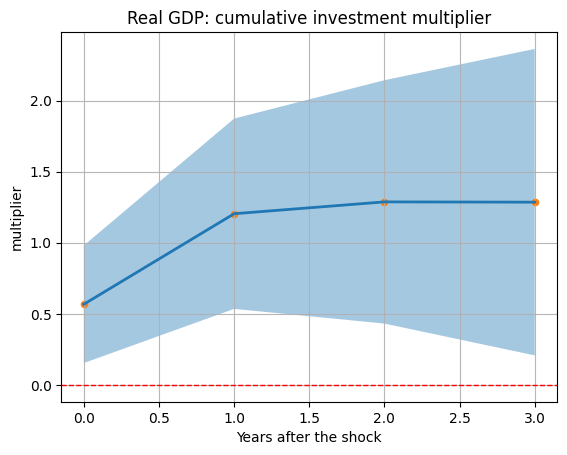

In [54]:
# Controlli baseline (come in R)
ctrl_base = ["growth_RGDP", "PDEBT", "forecasterror", "NOMLRATE", "REER"]

# (Opzionale) prova a tarare bandwidth DK se vuoi avvicinare ancora le bande a R
DK_BW = None  # esempio: 2

# GDP LP
lp_gdp = lp_lin_panel_py(
    data_set=dt,
    endog_data="log_RGDP",
    shock="forecasterror",
    l_exog_data=ctrl_base,
    lags_exog_data=2,
    confint=1,
    hor=3,
    entity_col="ccode",
    time_col="year_int",
    cumul_mult=True,
    dk_bandwidth=DK_BW,
)

# Public investment ratio LP
lp_ratio = lp_lin_panel_py(
    data_set=dt,
    endog_data="PUBINVRATIO",
    shock="forecasterror",
    l_exog_data=ctrl_base,
    lags_exog_data=2,
    confint=1,
    hor=3,
    entity_col="ccode",
    time_col="year_int",
    cumul_mult=True,
    dk_bandwidth=DK_BW,
)

# rbar (media quota)
rbar = dt["PUBINVRATIO"].mean(skipna=True)
if np.isfinite(rbar) and rbar > 1:
    rbar = rbar / 100.0

mult_base = mult_from_ratio(lp_gdp, lp_ratio, rbar)
print(mult_base)

plot_mult(mult_base)

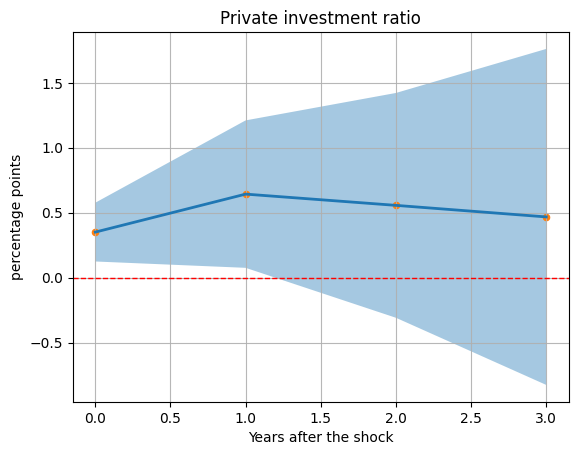

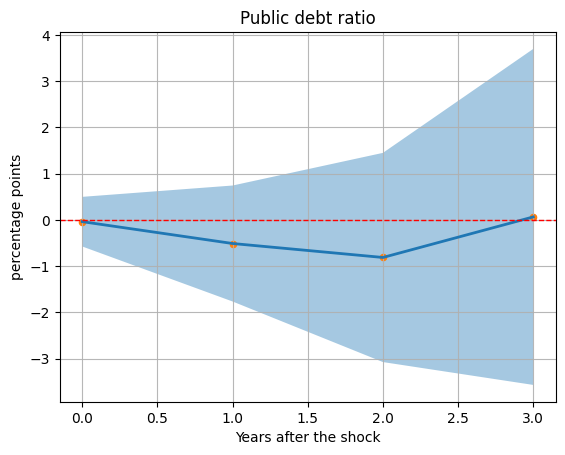

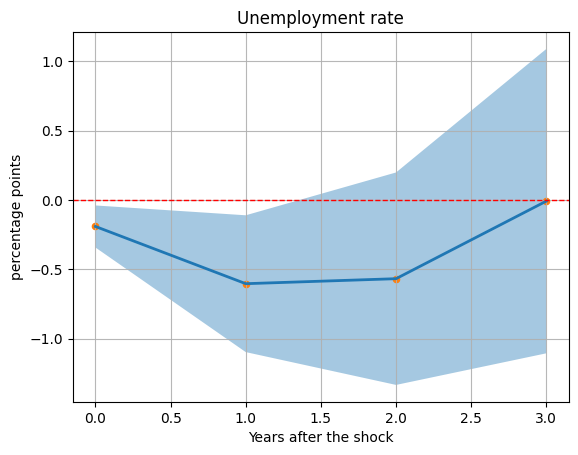

In [55]:
# Private inv
ctrl_priv = ["growth_RGDP", "PDEBT", "forecasterror", "NOMLRATE", "INVGDP_diff", "REER"]
lp_priv = lp_lin_panel_py(
    dt, "INVGDP", "forecasterror", ctrl_priv,
    lags_exog_data=2, confint=1, hor=3,
    cumul_mult=True, dk_bandwidth=DK_BW
)

# Debt
lp_debt = lp_lin_panel_py(
    dt, "PDEBT", "forecasterror", ctrl_base,
    lags_exog_data=2, confint=1, hor=3,
    cumul_mult=True, dk_bandwidth=DK_BW
)

# Unemployment
ctrl_unemp = ["growth_RGDP", "PDEBT", "forecasterror", "NOMLRATE", "UNRATE", "REER"]
lp_unemp = lp_lin_panel_py(
    dt, "UNRATE", "forecasterror", ctrl_unemp,
    lags_exog_data=2, confint=1, hor=3,
    cumul_mult=True, dk_bandwidth=DK_BW
)

plot_cum(lp_priv, scale=1, ttl="Private investment ratio", ylab="percentage points")
plot_cum(lp_debt, scale=1, ttl="Public debt ratio", ylab="percentage points")
plot_cum(lp_unemp, scale=1, ttl="Unemployment rate", ylab="percentage points")


In [33]:
def run_mult(ctrls, lags, data_set, r_share):
    gdp_lp = lp_lin_panel_py(data_set, "log_RGDP", "forecasterror", ctrls, lags_exog_data=lags, confint=1, hor=3)
    ratio_lp = lp_lin_panel_py(data_set, "PUBINVRATIO", "forecasterror", ctrls, lags_exog_data=lags, confint=1, hor=3)
    return mult_from_ratio(gdp_lp, ratio_lp, r_share)

# Robustness 1: OUTPUTGAP instead of growth_RGDP
ctrl_rob1 = ["OUTPUTGAP", "PDEBT", "forecasterror", "NOMLRATE", "REER"]
mult_rob1 = run_mult(ctrl_rob1, lags=2, data_set=dt, r_share=rbar)
print(mult_rob1)

# Robustness 2: lags = 3
mult_rob2 = run_mult(ctrl_base, lags=3, data_set=dt, r_share=rbar)
print(mult_rob2)

# Robustness 3: add PRIMARYBAL
ctrl_rob3 = ["growth_RGDP", "PDEBT", "forecasterror", "NOMLRATE", "PRIMARYBAL", "REER"]
mult_rob3 = run_mult(ctrl_rob3, lags=2, data_set=dt, r_share=rbar)
print(mult_rob3)

# Robustness 4: exclude Ireland
dt_no_irl = dt[dt["ccode"] != "IRL"].copy()
rbar_no_irl = np.nanmean(dt_no_irl["PUBINVRATIO"].to_numpy(dtype=float))
if np.isfinite(rbar_no_irl) and rbar_no_irl > 1:
    rbar_no_irl = rbar_no_irl / 100.0
mult_rob4 = run_mult(ctrl_base, lags=2, data_set=dt_no_irl, r_share=rbar_no_irl)
print(mult_rob4)

# Robustness 5: stop sample in 2019
dt_pre_covid = dt[dt["year_int"] <= 2019].copy()
rbar_pre_covid = np.nanmean(dt_pre_covid["PUBINVRATIO"].to_numpy(dtype=float))
if np.isfinite(rbar_pre_covid) and rbar_pre_covid > 1:
    rbar_pre_covid = rbar_pre_covid / 100.0
mult_rob5 = run_mult(ctrl_base, lags=2, data_set=dt_pre_covid, r_share=rbar_pre_covid)
print(mult_rob5)


   h  multiplier    lo_1se    hi_1se
0  0    0.574143  0.159101  0.989186
1  1    1.133925  0.499048  1.768801
2  2    1.161876  0.344730  1.979022
3  3    1.140558  0.085765  2.195352
   h  multiplier    lo_1se    hi_1se
0  0    0.233748 -0.034279  0.501775
1  1    0.885394  0.371322  1.399466
2  2    1.145295  0.346313  1.944277
3  3    1.353647  0.255188  2.452107
   h  multiplier    lo_1se    hi_1se
0  0    0.549712  0.140662  0.958762
1  1    1.175527  0.492082  1.858971
2  2    1.244446  0.377613  2.111279
3  3    1.243937  0.150854  2.337019
   h  multiplier    lo_1se    hi_1se
0  0    0.780063  0.354970  1.205156
1  1    1.363280  0.644321  2.082239
2  2    1.464659  0.569176  2.360141
3  3    1.419727  0.352672  2.486782
   h  multiplier    lo_1se    hi_1se
0  0    0.654508  0.185089  1.123928
1  1    1.188279  0.388436  1.988122
2  2    1.158907  0.162983  2.154831
3  3    1.131443 -0.077622  2.340508
